In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import waveresponse as wr
import warnings
warnings.filterwarnings("ignore") 

df = pd.read_csv('resources/diffraction_data.csv')
df

,omega,radiating_dof,influenced_dof,wave_direction,added_mass,radiation_damping,inertia_matrix,hydrostatic_stiffness,g,rho,...,wavenumber,wavelength,diffraction_force_real,diffraction_force_imag,Froude_Krylov_force_real,Froude_Krylov_force_imag,excitation_force_real,excitation_force_imag,RAO_real,RAO_imag
0,0.1,Surge,Surge,0.000000,243.932689,6.576024e-07,1088.802066,0.0,9.81,1025.0,...,0.002337,2688.270531,1.505086e-07,-5.589261e+00,0.000000e+00,-2.495922e+01,1.505086e-07,-3.054848e+01,3.671375e-12,2.292248e+00
1,0.1,Surge,Surge,0.261799,243.932689,6.576024e-07,1088.802066,0.0,9.81,1025.0,...,0.002337,2688.270531,1.453802e-07,-5.398813e+00,2.273737e-13,-2.410876e+01,1.453804e-07,-2.950757e+01,3.529449e-12,2.214141e+00
2,0.1,Surge,Surge,0.523599,243.932689,6.576024e-07,1088.802066,0.0,9.81,1025.0,...,0.002337,2688.270531,1.303443e-07,-4.840447e+00,2.273737e-13,-2.161533e+01,1.303446e-07,-2.645577e+01,3.163111e-12,1.985146e+00
3,0.1,Surge,Surge,1.570796,243.932689,6.576024e-07,1088.802066,0.0,9.81,1025.0,...,0.002337,2688.270531,1.110223e-16,1.110223e-16,0.000000e+00,-1.582068e-15,1.110223e-16,-1.471046e-15,8.400836e-17,1.174742e-16
4,0.1,Surge,Surge,3.141593,243.932689,6.576024e-07,1088.802066,0.0,9.81,1025.0,...,0.002337,2688.270531,-1.505086e-07,5.589261e+00,0.000000e+00,2.495922e+01,-1.505086e-07,3.054848e+01,-3.671232e-12,-2.292248e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,5.0,Yaw,Yaw,0.000000,344.357595,1.633789e+03,752.127048,0.0,9.81,1025.0,...,2.548420,2.465522,-5.115908e-13,7.105427e-13,-5.684342e-14,1.165290e-12,-5.684342e-13,1.875833e-12,-1.580216e-17,-4.303413e-17
8996,5.0,Yaw,Yaw,0.261799,344.357595,1.633789e+03,752.127048,0.0,9.81,1025.0,...,2.548420,2.465522,6.729395e+02,5.476536e+02,1.603953e+03,1.421085e-12,2.276893e+03,5.476536e+02,-8.175486e-02,4.384819e-03
8997,5.0,Yaw,Yaw,0.523599,344.357595,1.633789e+03,752.127048,0.0,9.81,1025.0,...,2.548420,2.465522,1.202264e+03,1.006330e+03,3.637985e+03,1.705303e-12,4.840249e+03,1.006330e+03,-1.722192e-01,1.461100e-02
8998,5.0,Yaw,Yaw,1.570796,344.357595,1.633789e+03,752.127048,0.0,9.81,1025.0,...,2.548420,2.465522,1.321609e-12,1.392664e-12,7.389644e-13,-4.547474e-13,2.060574e-12,9.379164e-13,3.049957e-16,1.788302e-17


In [32]:
df_mean = (
    df.groupby(["omega", "radiating_dof"], as_index=False)[["RAO_real", "RAO_imag"]]
      .mean()
)
df_mean

,omega,radiating_dof,RAO_real,RAO_imag
0,0.1,Heave,9.999997e-01,5.278722e-10
1,0.1,Pitch,-5.062604e-13,-8.476520e-04
2,0.1,Roll,-2.209852e-15,-2.253193e-18
3,0.1,Surge,1.338557e-12,8.398574e-01
4,0.1,Sway,5.954028e-13,8.062869e-01
...,...,...,...,...
295,5.0,Pitch,6.725220e-02,4.530550e-02
296,5.0,Roll,9.762361e-18,1.248999e-17
297,5.0,Surge,3.743890e-02,-3.480529e-02
298,5.0,Sway,1.798253e-02,6.386281e-02


In [33]:
# creative wave using jonswap spectrum
# hs - wave height
# tp - peak period
# dirp is peak direction
def create_wave(freq, dirs, hs, tp, dirp):
    _, vals = wr.JONSWAP(freq, freq_hz=True)(hs, tp)
    spread_fun = wr.CosineFullSpreading(s=2, degrees=True)

    wave = wr.WaveSpectrum.from_spectrum1d(
        freq,
        dirs,
        vals,
        spread_fun,
        dirp,
        freq_hz=False,
        degrees=True,
        clockwise=False,
        waves_coming_from=False,
    )
    return wave

In [34]:
def custom_RAO(dof):
    sub = (
        df_mean[df_mean["radiating_dof"] == dof]
        .sort_values("omega")
    )
    omega = sub["omega"].to_numpy()      
    rao_real = sub["RAO_real"].to_numpy()    
    rao_imag = sub["RAO_imag"].to_numpy() 

    dirs = np.array([0.0])                  
    rao_complex = rao_real + 1j * rao_imag
    rao_vals = rao_complex[:, None] 
    
    rao = wr.RAO(
        omega,
        dirs,
        rao_vals,
        freq_hz=False,       
        degrees=True,       
        clockwise=False,
        waves_coming_from=True,
    )
    return rao

In [35]:

def rao_response_plots_freq(ax, dofs, wave, heading):
    for i, dof in enumerate(dofs):
        rao = custom_RAO(dof)
        response = wr.calculate_response(rao, wave, heading, heading_degrees=True)
        _, response_spectrum = response.spectrum1d(axis=1)
 
        x = np.linspace(0, 5, response_spectrum.size)
        ax[i].plot(x, response_spectrum)
        ax[i].set_title(f'{dof} ({heading} deg)')
        ax[i].set_ylabel('RAO Response')
        ax[i].set_xlabel('Omega (rad/s)')
    return ax

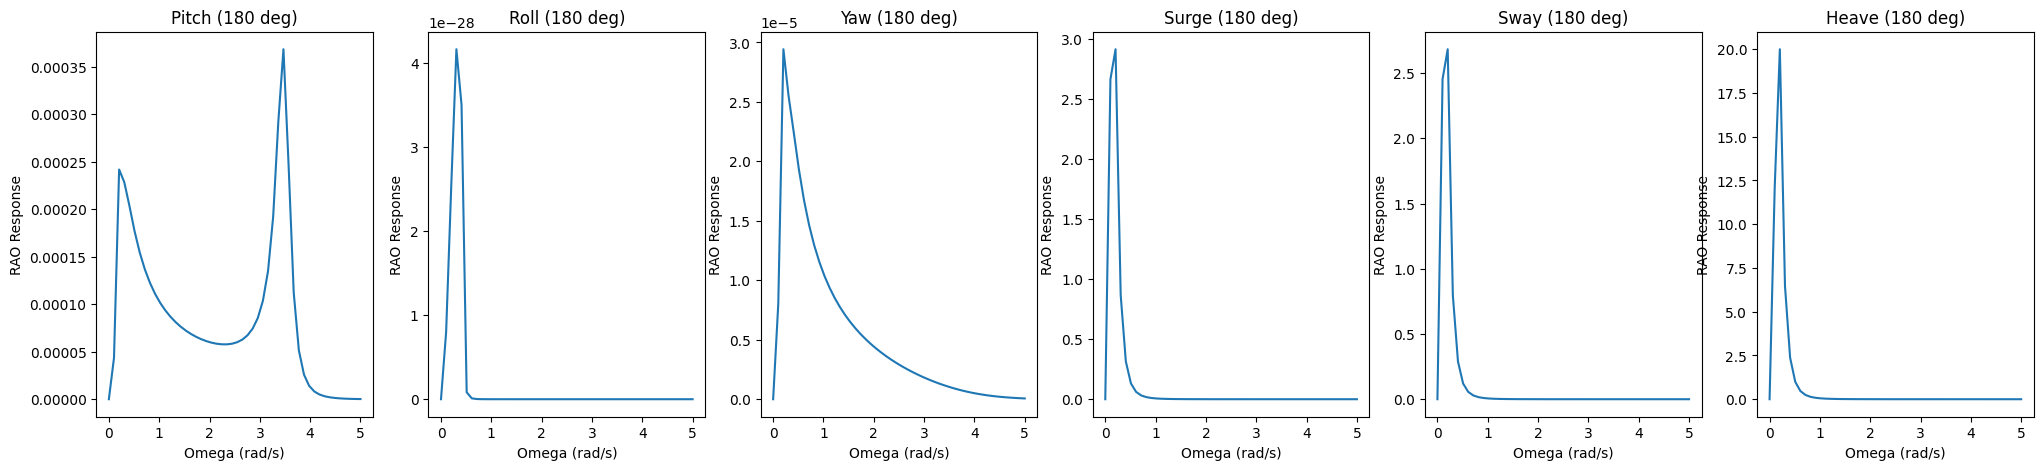

In [ ]:
# create_wave() params
freq = np.linspace(0.1, 5, 50)
dirs = np.linspace(0.0, 360.0, endpoint=False)
hs = 10 
tp = 4 
gamma = 3.3  

# rao_response_plot() params
heading = 30
dofs = ["Pitch", "Roll", "Yaw", "Surge", "Sway", "Heave"]
fig, ax = plt.subplots(1, 6, figsize=(25, 5))

wave = create_wave(freq, dirs, hs, tp, heading)
ax = rao_response_plots_freq(ax, dofs, wave, heading)
plt.show()